In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from include.beauti_print import *
from include.create_basketball_player_data import *
from include.basketball_players_hypothesis_testing_functions import *
pd.set_option('expand_frame_repr', False)
from scipy.stats import shapiro, f_oneway, kruskal

<div class="alert alert-block alert-success">
To keep the notebook clean and make it more readable, I have kept all the user defined functions inside the include folder.
</div>

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;">
Intro
</div>

ou can find a plethora of viewpoints online, with some asserting that taller basketball players excel more, while others contend that height is not a pivotal factor. Hence, we will proceed with hypothesis testing.
<br><br>
<b>Our null hypothesis (H0) states:</b> Height has no significant effect on basketball performance.<br>
<b>Our alternative hypothesis (H1) posits:</b> Height does have a significant effect on basketball 

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;">
Dataset building
</div>

I have collected the required data for the project from two website.

1. __[number fire](https://www.numberfire.com)__: A website that provides details such as team ranking, players ranking, players statistics etc.
1. __[the sports db](https://www.thesportsdb.com/free_sports_api)__: Which provides api for datils about verious sports, players, team etc (I am using this api to fetch basic details like players age, height, weight etc)

#### How to create the dataset ?

1. You can follow the below three steps.
1. You can download the dataset from __[here](https://github.com/manab36/Data-Analysis/blob/bd0414d026b2720f96bf34bf7d981c692279a542/dataset/basketball_players.csv)__.
1. You can modify(the output location if needed) and run the `include/create_basketball_player_data.py` script.

Incase of option 2 or 3 follow from dataset exploring


#

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Step I. webscraping from <a href="https://www.numberfire.com">numberfire</a>
</div>

<p>

From the numberfire website we will scape the data using __[BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/)__. <br>
1. To Get all players name and rankings participating in NBA.
1. To get all teams name and rankings participating in NBA.
</p>

In [2]:
players_details_df= get_players_details_numberfire()
players_details_df

player      efficiency                statistics        \
                        name rank       nerd nf_eff fantasy        mpg   ppg   
0               Nikola Jokic    1       23.6    7.4   14.67       34.5  26.1   
1    Shai Gilgeous-Alexander    2       23.4    7.4   13.47       34.4  30.3   
2      Giannis Antetokounmpo    3       19.6    6.2    6.24       35.2  30.8   
3                Luka Doncic    4       16.6    5.3    8.73       37.4  34.0   
4              Anthony Davis    5       14.0    4.3   13.60       35.9  24.7   
..                       ...  ...        ...    ...     ...        ...   ...   
494            Malachi Flynn  492       -2.7   -2.9   -6.79       11.8   4.6   
495           Keldon Johnson  496       -2.8   -1.1    0.00       29.6  15.8   
496          Nah'Shon Hyland  496       -2.8   -5.0   -8.15       13.6   5.8   
497           Gordon Hayward  498       -2.9   -2.0   -4.87       25.0  10.0   
498           Doug McDermott  498       -2.9   -2.7   -6.27       14.4   5.5   

                
      rpg  apg  
0    12.3  9.0  
1     5.5  6.3  
2    11.5  6.4  
3     9.1  9.8  
4    12.7  3.6  
..    ...  ...  
494   1.6  1.6  
495   5.5  2.9  
496   1.1  2.2  
497   3.7  3.3  
498   1.0  1.1  

[499 rows x 9 columns]

In [3]:
players_details_df.columns = [i+'_'+v for i,v in players_details_df.columns.tolist()]
players_details_df

,player_name,player_rank,efficiency_nerd,efficiency_nf_eff,efficiency_fantasy,statistics_mpg,statistics_ppg,statistics_rpg,statistics_apg
0,Nikola Jokic,1,23.6,7.4,14.67,34.5,26.1,12.3,9.0
1,Shai Gilgeous-Alexander,2,23.4,7.4,13.47,34.4,30.3,5.5,6.3
2,Giannis Antetokounmpo,3,19.6,6.2,6.24,35.2,30.8,11.5,6.4
3,Luka Doncic,4,16.6,5.3,8.73,37.4,34.0,9.1,9.8
4,Anthony Davis,5,14.0,4.3,13.60,35.9,24.7,12.7,3.6
...,...,...,...,...,...,...,...,...,...
494,Malachi Flynn,492,-2.7,-2.9,-6.79,11.8,4.6,1.6,1.6
495,Keldon Johnson,496,-2.8,-1.1,0.00,29.6,15.8,5.5,2.9
496,Nah'Shon Hyland,496,-2.8,-5.0,-8.15,13.6,5.8,1.1,2.2
497,Gordon Hayward,498,-2.9,-2.0,-4.87,25.0,10.0,3.7,3.3


In [4]:
players_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   player_name         499 non-null    object
 1   player_rank         499 non-null    object
 2   efficiency_nerd     499 non-null    object
 3   efficiency_nf_eff   499 non-null    object
 4   efficiency_fantasy  499 non-null    object
 5   statistics_mpg      499 non-null    object
 6   statistics_ppg      499 non-null    object
 7   statistics_rpg      499 non-null    object
 8   statistics_apg      499 non-null    object
dtypes: object(9)
memory usage: 35.2+ KB


In [5]:
team_details_df= get_team_details_numberfire()
team_details_df

,team,team_rank,conference,division
0,Boston Celtics,1,Eastern Conference,Atlantic
1,New York Knicks,8,Eastern Conference,Atlantic
2,Philadelphia 76ers,13,Eastern Conference,Atlantic
3,Brooklyn Nets,22,Eastern Conference,Atlantic
4,Toronto Raptors,23,Eastern Conference,Atlantic
5,Milwaukee Bucks,6,Eastern Conference,Central
6,Cleveland Cavaliers,9,Eastern Conference,Central
7,Indiana Pacers,15,Eastern Conference,Central
8,Chicago Bulls,20,Eastern Conference,Central
9,Detroit Pistons,27,Eastern Conference,Central


In [6]:
team_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   team        30 non-null     object
 1   team_rank   30 non-null     object
 2   conference  30 non-null     object
 3   division    30 non-null     object
dtypes: object(4)
memory usage: 1.1+ KB


<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Step II. api call <a href="https://www.thesportsdb.com/free_sports_api">thesportsdb</a>
</div>
<p>

To get the general details about the players from the list we got from the numberfire website we will call api using __[request](https://requests.readthedocs.io/en/latest/)__. <br>
The data here is noisy (some columns have different types of values like for some player the api will provide the height in cm, in feet, maximum having both etc) and have too many columns, so we also need to clean the data a bit before making the final dataset
</p>

In [7]:
players_details_2_df= get_players_details_by_list_name(players_details_df['player_name'])
players_details_2_df

100%|██████████| 499/499 [11:43<00:00,  1.41s/it]


,idPlayer,idTeam,idTeam2,idTeamNational,idSoccerXML,idAPIfootball,idPlayerManager,idWikidata,strNationality,strPlayer,...,strThumb,strCutout,strRender,strBanner,strFanart1,strFanart2,strFanart3,strFanart4,strCreativeCommons,strLocked
0,34165427,134885,0,None,None,None,None,None,Serbia,Nikola Jokić,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,None,No,unlocked
1,34164224,134887,0,None,None,None,None,None,Canada,Shai Gilgeous-Alexander,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,No,unlocked
2,34161165,134874,0,None,None,None,None,None,Greece,Giannis Antetokounmpo,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,None,No,unlocked
3,34160864,134875,0,None,0,None,None,None,Slovenia,Luka Dončić,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,No,unlocked
4,34154079,134867,0,None,0,None,None,None,USA,Anthony Davis,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,No,unlocked
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,34196139,134886,0,None,None,None,None,None,United States,Jaden McDaniels,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,None,No,unlocked
472,34196120,134872,0,None,None,None,None,None,United States,Malachi Flynn,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,None,No,unlocked
473,34168040,134879,136741,None,None,None,None,None,United States,Keldon Johnson,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,None,No,unlocked
474,34164017,134887,0,None,None,None,None,None,United States,Gordon Hayward,...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,https://www.thesportsdb.com/images/media/playe...,None,None,None,None,None,No,unlocked


In [8]:
players_details_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   idPlayer            476 non-null    object
 1   idTeam              476 non-null    object
 2   idTeam2             473 non-null    object
 3   idTeamNational      0 non-null      object
 4   idSoccerXML         43 non-null     object
 5   idAPIfootball       6 non-null      object
 6   idPlayerManager     2 non-null      object
 7   idWikidata          0 non-null      object
 8   strNationality      476 non-null    object
 9   strPlayer           476 non-null    object
 10  strPlayerAlternate  453 non-null    object
 11  strTeam             476 non-null    object
 12  strTeam2            473 non-null    object
 13  strSport            476 non-null    object
 14  intSoccerXMLTeamID  2 non-null      object
 15  dateBorn            476 non-null    object
 16  strNumber           473 no

In [111]:
clean_player_details_df= clean_player_details_data(players_details_2_df)
clean_player_details_df

,player_name,team,sport,birth_date,birth_location,active_status,gender,height_in_cm,weight_in_lb
0,Nikola Jokić,Denver Nuggets,Basketball,1995-02-19,"Sombor, Serbia, FR Yugoslavia",True,M,211.0,284.0
1,Shai Gilgeous-Alexander,Oklahoma City Thunder,Basketball,1998-07-12,"Toronto, Ontario",True,M,198.0,180.0
2,Giannis Antetokounmpo,Milwaukee Bucks,Basketball,1994-12-06,"Athens, Greece",True,M,211.0,242.0
3,Luka Dončić,Dallas Mavericks,Basketball,1999-02-28,"Ljubljana, Slovenia",True,M,201.0,230.0
4,Anthony Davis,Los Angeles Lakers,Basketball,1993-03-11,"Chicago, Illinois",True,M,208.0,253.0
...,...,...,...,...,...,...,...,...,...
471,Jaden McDaniels,Minnesota Timberwolves,Basketball,2000-09-29,"Federal Way, Washington, U.S.",True,M,206.0,185.0
472,Malachi Flynn,Detroit Pistons,Basketball,1998-05-10,"Tacoma, Washington, U.S.",True,M,185.0,175.0
473,Keldon Johnson,San Antonio Spurs,Basketball,1999-11-11,"Chesterfield, Virginia",True,M,196.0,220.0
474,Gordon Hayward,Oklahoma City Thunder,Basketball,1990-03-23,"Indianapolis, Indiana",True,M,201.0,225.0


In [112]:
clean_player_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_name     476 non-null    object 
 1   team            476 non-null    object 
 2   sport           476 non-null    object 
 3   birth_date      476 non-null    object 
 4   birth_location  476 non-null    object 
 5   active_status   476 non-null    bool   
 6   gender          476 non-null    object 
 7   height_in_cm    471 non-null    float64
 8   weight_in_lb    469 non-null    float64
dtypes: bool(1), float64(2), object(6)
memory usage: 30.3+ KB


<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Step III. merge all the details in one table
</div>

1. Merge the table with the general data of the player, with the teams details
1. Merge the previously merged data with players ranking data
1. Dump the final table to a csv file


In [113]:
merge_df= clean_player_details_df.merge(team_details_df, on='team', how= 'left', indicator=True)
merge_df= merge_df[merge_df["_merge"]== "both"].drop(columns= "_merge")
merge_df

,player_name,team,sport,birth_date,birth_location,active_status,gender,height_in_cm,weight_in_lb,team_rank,conference,division
0,Nikola Jokić,Denver Nuggets,Basketball,1995-02-19,"Sombor, Serbia, FR Yugoslavia",True,M,211.0,284.0,5,Western Conference,Northwest
1,Shai Gilgeous-Alexander,Oklahoma City Thunder,Basketball,1998-07-12,"Toronto, Ontario",True,M,198.0,180.0,2,Western Conference,Northwest
2,Giannis Antetokounmpo,Milwaukee Bucks,Basketball,1994-12-06,"Athens, Greece",True,M,211.0,242.0,6,Eastern Conference,Central
3,Luka Dončić,Dallas Mavericks,Basketball,1999-02-28,"Ljubljana, Slovenia",True,M,201.0,230.0,11,Western Conference,Southwest
4,Anthony Davis,Los Angeles Lakers,Basketball,1993-03-11,"Chicago, Illinois",True,M,208.0,253.0,18,Western Conference,Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...
471,Jaden McDaniels,Minnesota Timberwolves,Basketball,2000-09-29,"Federal Way, Washington, U.S.",True,M,206.0,185.0,3,Western Conference,Northwest
472,Malachi Flynn,Detroit Pistons,Basketball,1998-05-10,"Tacoma, Washington, U.S.",True,M,185.0,175.0,27,Eastern Conference,Central
473,Keldon Johnson,San Antonio Spurs,Basketball,1999-11-11,"Chesterfield, Virginia",True,M,196.0,220.0,25,Western Conference,Southwest
474,Gordon Hayward,Oklahoma City Thunder,Basketball,1990-03-23,"Indianapolis, Indiana",True,M,201.0,225.0,2,Western Conference,Northwest


In [114]:
merge_df_2= merge_df.merge(players_details_df, on='player_name', how= 'left', indicator=True)
final_data= merge_df_2[merge_df_2["_merge"]== "both"].drop(columns= "_merge")
final_data

,player_name,team,sport,birth_date,birth_location,active_status,gender,height_in_cm,weight_in_lb,team_rank,conference,division,player_rank,efficiency_nerd,efficiency_nf_eff,efficiency_fantasy,statistics_mpg,statistics_ppg,statistics_rpg,statistics_apg
1,Shai Gilgeous-Alexander,Oklahoma City Thunder,Basketball,1998-07-12,"Toronto, Ontario",True,M,198.0,180.0,2,Western Conference,Northwest,2,23.4,7.4,13.47,34.4,30.3,5.5,6.3
2,Giannis Antetokounmpo,Milwaukee Bucks,Basketball,1994-12-06,"Athens, Greece",True,M,211.0,242.0,6,Eastern Conference,Central,3,19.6,6.2,6.24,35.2,30.8,11.5,6.4
4,Anthony Davis,Los Angeles Lakers,Basketball,1993-03-11,"Chicago, Illinois",True,M,208.0,253.0,18,Western Conference,Pacific,5,14.0,4.3,13.60,35.9,24.7,12.7,3.6
5,Jayson Tatum,Boston Celtics,Basketball,1998-03-03,"St. Louis, Missouri, USA",True,M,203.0,209.0,1,Eastern Conference,Atlantic,6,13.2,4.1,7.59,35.9,27.2,8.3,4.9
6,Jalen Brunson,New York Knicks,Basketball,1996-08-31,"New Brunswick, New Jersey",True,M,185.0,190.0,8,Eastern Conference,Atlantic,7,13.0,4.2,4.42,35.1,27.9,3.6,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,Jaden McDaniels,Minnesota Timberwolves,Basketball,2000-09-29,"Federal Way, Washington, U.S.",True,M,206.0,185.0,3,Western Conference,Northwest,492,-2.7,-1.1,-2.71,29.4,10.8,3.2,1.4
428,Malachi Flynn,Detroit Pistons,Basketball,1998-05-10,"Tacoma, Washington, U.S.",True,M,185.0,175.0,27,Eastern Conference,Central,492,-2.7,-2.9,-6.79,11.8,4.6,1.6,1.6
429,Keldon Johnson,San Antonio Spurs,Basketball,1999-11-11,"Chesterfield, Virginia",True,M,196.0,220.0,25,Western Conference,Southwest,496,-2.8,-1.1,0.00,29.6,15.8,5.5,2.9
430,Gordon Hayward,Oklahoma City Thunder,Basketball,1990-03-23,"Indianapolis, Indiana",True,M,201.0,225.0,2,Western Conference,Northwest,498,-2.9,-2.0,-4.87,25.0,10.0,3.7,3.3


In [115]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407 entries, 1 to 431
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         407 non-null    object 
 1   team                407 non-null    object 
 2   sport               407 non-null    object 
 3   birth_date          407 non-null    object 
 4   birth_location      407 non-null    object 
 5   active_status       407 non-null    bool   
 6   gender              407 non-null    object 
 7   height_in_cm        407 non-null    float64
 8   weight_in_lb        406 non-null    float64
 9   team_rank           407 non-null    object 
 10  conference          407 non-null    object 
 11  division            407 non-null    object 
 12  player_rank         407 non-null    object 
 13  efficiency_nerd     407 non-null    object 
 14  efficiency_nf_eff   407 non-null    object 
 15  efficiency_fantasy  407 non-null    object 
 16  statistics_mp

In [116]:
final_data.to_csv(R"dataset\basketball_players.csv", index= False)

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;">
Dataset Description and Preprocessing
</div>

#

##### efficiency matrices in NBA and what they stands for:

<table style= "font-family: arial, sans-serif; border-collapse: collapse; width: 100%;">
  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">short</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">full form</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">description</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">nerd</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">numberFire Efficiency Rating Derivative</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">d system of evaluating every player in the NBA based on various offensive and defensive efficiency metrics. NERD rating for players shows production in efficiency.escription</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">nf eff</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">nF Efficiency</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">metric measures a player's raw efficiency. More specifically, it is an estimate for the point differential that a league-average team would have with that player as one of the five starters. <br>It combines both offensive and defensive production on a per possession basis.</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">fantansy</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">fantansy</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">The NBA's standard fantasy points scoring system dictates: Points = 1.0 fantasy point. Rebounds = 1.2 fantasy points. Assists = 1.5 fantasy points. Steals = 3.0 fantasy points.</th>
  </tr>

</table>

##### statistics matrices in NBA and what they stands for:

<table style= "font-family: arial, sans-serif; border-collapse: collapse; width: 100%;">
  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">short</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">full form</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">description</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">mpg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Minutes Played Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">The average number of minutes a player has played per game. Formula: Minutes / Games</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">ppg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Points Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">is a statistical measure of a player's scoring per game. It is simply calculated by taking total points, and dividing it by total games over his over a season, career, or a stretch.</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">rpg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Rebounds Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">he average number of total rebounds per game. Formula: (RBO + RBD) / Games</th>
  </tr>

  <tr>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 10%">apg</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 20%">Assist Per Game</th>
    <th style= "border: 1px solid #dddddd; text-align: left; width: 70%">An assist is attributed to a player who passes the ball to a teammate in a way that leads directly to a score by field goal, meaning that they were "assisting" in the basket. An assist is also credited when a basket is awarded due to defensive goaltending.</th>
  </tr>

</table>

In [117]:
data= pd.read_csv(R"dataset\basketball_players.csv")
data

,player_name,team,sport,birth_date,birth_location,active_status,gender,height_in_cm,weight_in_lb,team_rank,conference,division,player_rank,efficiency_nerd,efficiency_nf_eff,efficiency_fantasy,statistics_mpg,statistics_ppg,statistics_rpg,statistics_apg
0,Shai Gilgeous-Alexander,Oklahoma City Thunder,Basketball,1998-07-12,"Toronto, Ontario",True,M,198.0,180.0,2,Western Conference,Northwest,2,23.4,7.4,13.47,34.4,30.3,5.5,6.3
1,Giannis Antetokounmpo,Milwaukee Bucks,Basketball,1994-12-06,"Athens, Greece",True,M,211.0,242.0,6,Eastern Conference,Central,3,19.6,6.2,6.24,35.2,30.8,11.5,6.4
2,Anthony Davis,Los Angeles Lakers,Basketball,1993-03-11,"Chicago, Illinois",True,M,208.0,253.0,18,Western Conference,Pacific,5,14.0,4.3,13.60,35.9,24.7,12.7,3.6
3,Jayson Tatum,Boston Celtics,Basketball,1998-03-03,"St. Louis, Missouri, USA",True,M,203.0,209.0,1,Eastern Conference,Atlantic,6,13.2,4.1,7.59,35.9,27.2,8.3,4.9
4,Jalen Brunson,New York Knicks,Basketball,1996-08-31,"New Brunswick, New Jersey",True,M,185.0,190.0,8,Eastern Conference,Atlantic,7,13.0,4.2,4.42,35.1,27.9,3.6,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,Jaden McDaniels,Minnesota Timberwolves,Basketball,2000-09-29,"Federal Way, Washington, U.S.",True,M,206.0,185.0,3,Western Conference,Northwest,492,-2.7,-1.1,-2.71,29.4,10.8,3.2,1.4
403,Malachi Flynn,Detroit Pistons,Basketball,1998-05-10,"Tacoma, Washington, U.S.",True,M,185.0,175.0,27,Eastern Conference,Central,492,-2.7,-2.9,-6.79,11.8,4.6,1.6,1.6
404,Keldon Johnson,San Antonio Spurs,Basketball,1999-11-11,"Chesterfield, Virginia",True,M,196.0,220.0,25,Western Conference,Southwest,496,-2.8,-1.1,0.00,29.6,15.8,5.5,2.9
405,Gordon Hayward,Oklahoma City Thunder,Basketball,1990-03-23,"Indianapolis, Indiana",True,M,201.0,225.0,2,Western Conference,Northwest,498,-2.9,-2.0,-4.87,25.0,10.0,3.7,3.3


<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Only keeping currently active Basketball Male players in the dataset
</div>

`At the I was building data dataset I didn't encounter any records which needed to be dropped based on above condition`

In [118]:
data= clean_non_active_players(data)
data

**********************************************************************************************************************************
Cleaning Non active players, Not male players and Non basketball players
**********************************************************************************************************************************


,player_name,team,birth_date,birth_location,height_in_cm,weight_in_lb,team_rank,conference,division,player_rank,efficiency_nerd,efficiency_nf_eff,efficiency_fantasy,statistics_mpg,statistics_ppg,statistics_rpg,statistics_apg
0,Shai Gilgeous-Alexander,Oklahoma City Thunder,1998-07-12,"Toronto, Ontario",198.0,180.0,2,Western Conference,Northwest,2,23.4,7.4,13.47,34.4,30.3,5.5,6.3
1,Giannis Antetokounmpo,Milwaukee Bucks,1994-12-06,"Athens, Greece",211.0,242.0,6,Eastern Conference,Central,3,19.6,6.2,6.24,35.2,30.8,11.5,6.4
2,Anthony Davis,Los Angeles Lakers,1993-03-11,"Chicago, Illinois",208.0,253.0,18,Western Conference,Pacific,5,14.0,4.3,13.60,35.9,24.7,12.7,3.6
3,Jayson Tatum,Boston Celtics,1998-03-03,"St. Louis, Missouri, USA",203.0,209.0,1,Eastern Conference,Atlantic,6,13.2,4.1,7.59,35.9,27.2,8.3,4.9
4,Jalen Brunson,New York Knicks,1996-08-31,"New Brunswick, New Jersey",185.0,190.0,8,Eastern Conference,Atlantic,7,13.0,4.2,4.42,35.1,27.9,3.6,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,Jaden McDaniels,Minnesota Timberwolves,2000-09-29,"Federal Way, Washington, U.S.",206.0,185.0,3,Western Conference,Northwest,492,-2.7,-1.1,-2.71,29.4,10.8,3.2,1.4
403,Malachi Flynn,Detroit Pistons,1998-05-10,"Tacoma, Washington, U.S.",185.0,175.0,27,Eastern Conference,Central,492,-2.7,-2.9,-6.79,11.8,4.6,1.6,1.6
404,Keldon Johnson,San Antonio Spurs,1999-11-11,"Chesterfield, Virginia",196.0,220.0,25,Western Conference,Southwest,496,-2.8,-1.1,0.00,29.6,15.8,5.5,2.9
405,Gordon Hayward,Oklahoma City Thunder,1990-03-23,"Indianapolis, Indiana",201.0,225.0,2,Western Conference,Northwest,498,-2.9,-2.0,-4.87,25.0,10.0,3.7,3.3


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         407 non-null    object 
 1   team                407 non-null    object 
 2   birth_date          407 non-null    object 
 3   birth_location      406 non-null    object 
 4   height_in_cm        407 non-null    float64
 5   weight_in_lb        406 non-null    float64
 6   team_rank           407 non-null    int64  
 7   conference          407 non-null    object 
 8   division            407 non-null    object 
 9   player_rank         407 non-null    int64  
 10  efficiency_nerd     407 non-null    float64
 11  efficiency_nf_eff   407 non-null    float64
 12  efficiency_fantasy  407 non-null    float64
 13  statistics_mpg      407 non-null    float64
 14  statistics_ppg      407 non-null    float64
 15  statistics_rpg      407 non-null    float64
 16  statisti

<div style=" line-height: 90px;height: 90px;text-align: center; font-size: 60px; background-color: NavajoWhite ; color: black;">
Hypothesis testing ( based on nerd)
</div>

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Colomuns selections and data cleaning for Hypothesis testing
</div>

In [270]:
data.columns

Index(['player_name', 'team', 'birth_date', 'birth_location', 'height_in_cm',
       'weight_in_lb', 'team_rank', 'conference', 'division', 'player_rank',
       'efficiency_nerd', 'efficiency_nf_eff', 'efficiency_fantasy',
       'statistics_mpg', 'statistics_ppg', 'statistics_rpg', 'statistics_apg'],
      dtype='object')

In [342]:
htest_nerd_df= data[["player_name", "height_in_cm", "player_rank", "efficiency_nerd"]]
htest_nerd_df

,player_name,height_in_cm,player_rank,efficiency_nerd
0,Shai Gilgeous-Alexander,198.0,2,23.4
1,Giannis Antetokounmpo,211.0,3,19.6
2,Anthony Davis,208.0,5,14.0
3,Jayson Tatum,203.0,6,13.2
4,Jalen Brunson,185.0,7,13.0
...,...,...,...,...
402,Jaden McDaniels,206.0,492,-2.7
403,Malachi Flynn,185.0,492,-2.7
404,Keldon Johnson,196.0,496,-2.8
405,Gordon Hayward,201.0,498,-2.9


`cleaning outliers`

************************************************************************************************************
Removing outlier in col: ['efficiency_nerd', 'height_in_cm']
************************************************************************************************************
*You have selected Q1= 10 percentile 
and Q3= 20 percentile

*Lowerbound: -2.9000000000000004 
and Upperbound: -0.4999999999999998
Before cleaning number of rows: 407
 After cleaning number of rows: 165
*242 rows removed



*You have selected Q1= 10 percentile 
and Q3= 20 percentile

*Lowerbound: 183.50000000000006 
and Upperbound: 198.7
Before cleaning number of rows: 165
 After cleaning number of rows: 98
*67 rows removed





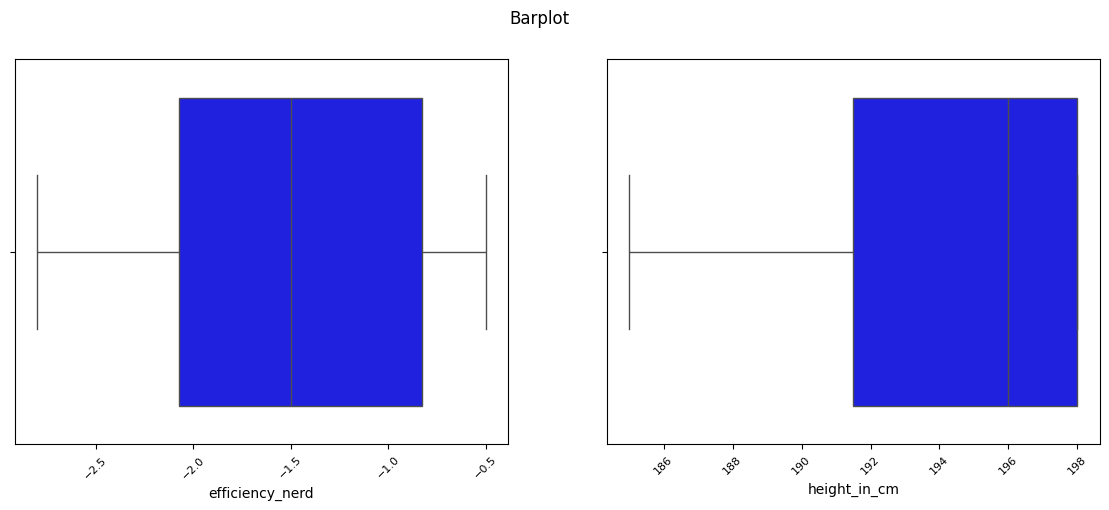

In [343]:
cleaned_htest_nerd_df= outlier_remover(htest_nerd_df, ["efficiency_nerd", "height_in_cm"], 10, 20)

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Check if the distribution for column <b>efficiency_nerd</b> is nornaml distribution or not
</div>

1. Devide the players into different Height groups
1. plot histogram for each groups
1. Shapiro test for each group :Shapiro-Wilk test is a test of normality, it determines whether the given sample comes from the normal distribution or not. Shapiro-Wilk’s test or Shapiro test is a normality test in frequentist statistics. The null hypothesis of Shapiro’s test is that the population is distributed normally.
    - Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
    - Ha(Rejected): Sample is not from the normal distributions.


In [344]:
cleaned_htest_nerd_df

,player_name,height_in_cm,player_rank,efficiency_nerd
243,De'Anthony Melton,188.0,304,-0.5
245,Jahmi'us Ramsey,191.0,304,-0.5
247,Justin Champagnie,198.0,304,-0.5
248,Terry Taylor,196.0,304,-0.5
249,Seth Lundy,198.0,304,-0.5
...,...,...,...,...
398,Jalen Green,193.0,483,-2.6
399,Jordan Hawkins,196.0,483,-2.6
401,Josh Green,196.0,492,-2.7
403,Malachi Flynn,185.0,492,-2.7


In [345]:
cleaned_htest_nerd_df["height_in_cm"].min(), cleaned_htest_nerd_df["height_in_cm"].max()

(185.0, 198.0)

In [376]:
temp= cleaned_htest_nerd_df.copy()

htest_g1= temp[temp["height_in_cm"] < 188.25]
temp= temp[temp["height_in_cm"]>= 188.25]

htest_g2= temp[temp["height_in_cm"] < 191.5]
temp= temp[temp["height_in_cm"]>= 191.5]

htest_g3= temp[temp["height_in_cm"] < 194.75]
temp= temp[temp["height_in_cm"]>= 194.75]

htest_g4= temp.copy()
del(temp)


htest_groups= [htest_g1, htest_g2, htest_g3, htest_g4]

group 1: ShapiroResult(statistic=0.8951414320431479, pvalue=0.09590309510332531)
group 2: ShapiroResult(statistic=0.9612496800062384, pvalue=0.7871823794923569)
group 3: ShapiroResult(statistic=0.8838826006242181, pvalue=0.036773010908073805)
group 4: ShapiroResult(statistic=0.9318663727797429, pvalue=0.003544906609921919)


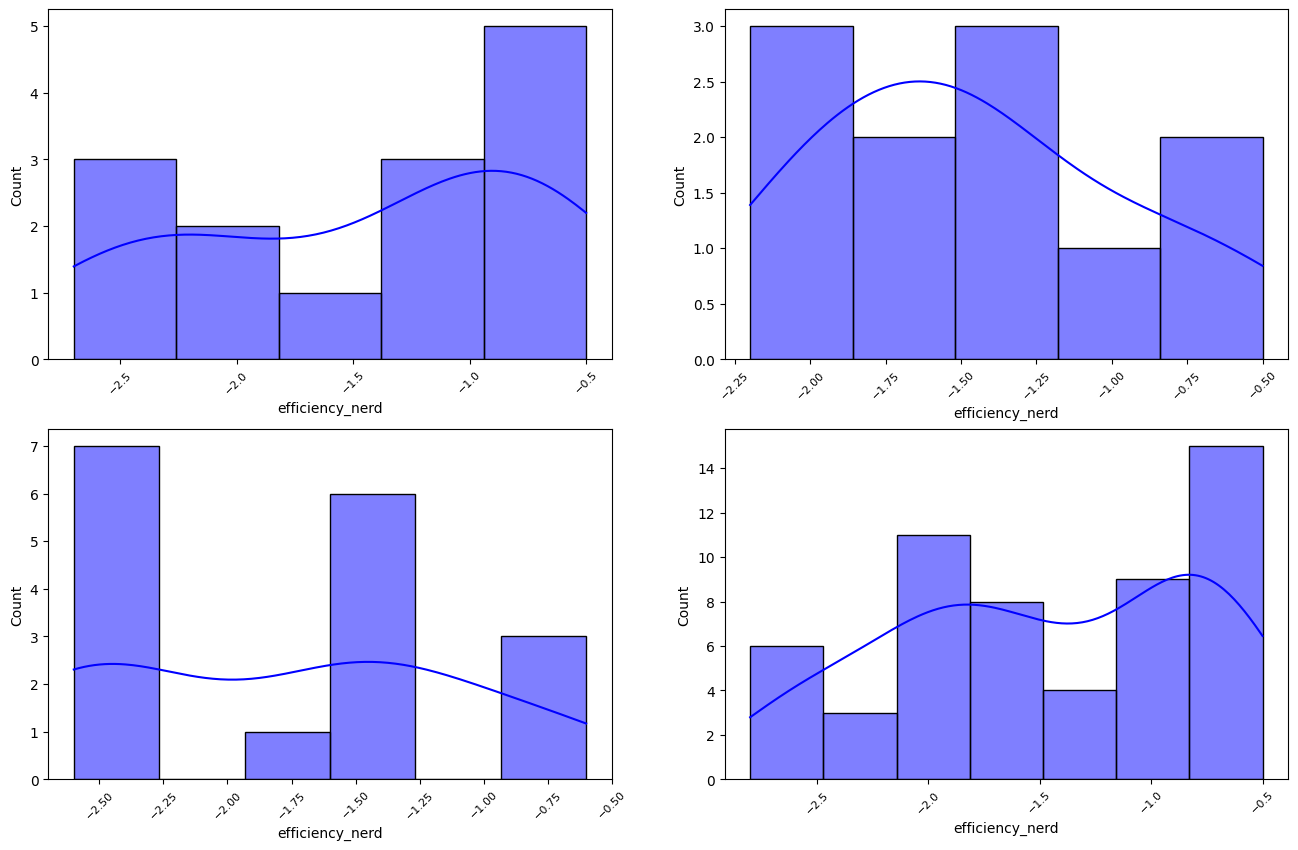

In [387]:
i=0
fig= plt.figure(figsize=(16,10))
for htest_g in htest_groups:
    i+=1
    

    plt.subplot(2,2,i)
    sns.histplot(data=htest_g,x= "efficiency_nerd", color="blue", kde= True)
    plt.xticks(rotation=45,fontsize=8)
    print(f"group {i}: {shapiro(htest_g["efficiency_nerd"])}")



ShapiroResult(statistic=0.9379851954620491, pvalue=0.00017069478580000836)


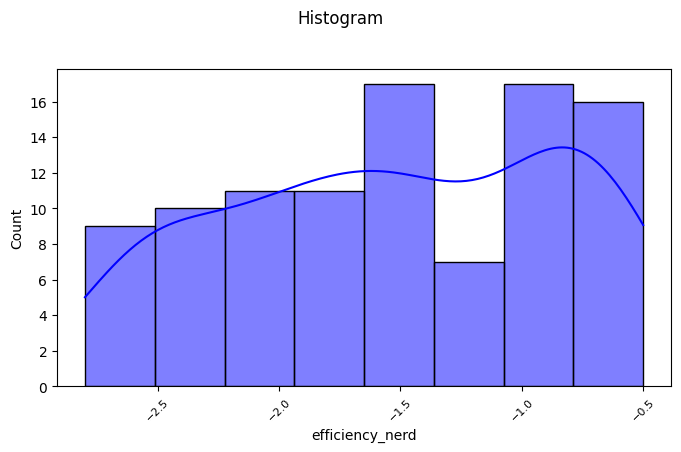

In [389]:
fig= plt.figure(figsize=(8,5))

plt.subplot(111)
sns.histplot(data=cleaned_htest_nerd_df,x= "efficiency_nerd", color="blue", kde= True)

fig.tight_layout(pad=5.0)
plt.xticks(rotation=45,fontsize=8)
fig.suptitle("Histogram")

print(f"{shapiro(cleaned_htest_nerd_df["efficiency_nerd"])}")

<div class="alert alert-block alert-info">
<b>Findings:</b> From above shapiro test and histograms the distribution is not normal distribution.<br>
</div>


So now we have 2 options:

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Option 1. Using ANOVA
</div>

- Step 1. Transform the right skewed data to normal distribution.
    - use Standardization if `mean is '0' and standard deviation is 1`
    - normalization
- Step 2. Peroform the ANOVA test.

In [390]:
print(f"Mean: {cleaned_htest_nerd_df["efficiency_nerd"].mean()}\nStandard deviation: {cleaned_htest_nerd_df["efficiency_nerd"].std()}")

Mean: -1.519387755102041
Standard deviation: 0.6861904642667214


Mean max scaling

In [391]:
cleaned_htest_nerd_df_2= cleaned_htest_nerd_df
cleaned_htest_nerd_df_2["efficiency_nerd"] =( cleaned_htest_nerd_df_2["efficiency_nerd"] - cleaned_htest_nerd_df_2["efficiency_nerd"].mean() ) / ( cleaned_htest_nerd_df_2["efficiency_nerd"].max() - cleaned_htest_nerd_df_2["efficiency_nerd"].min() )

Text(0.5, 0.98, 'Histogram')

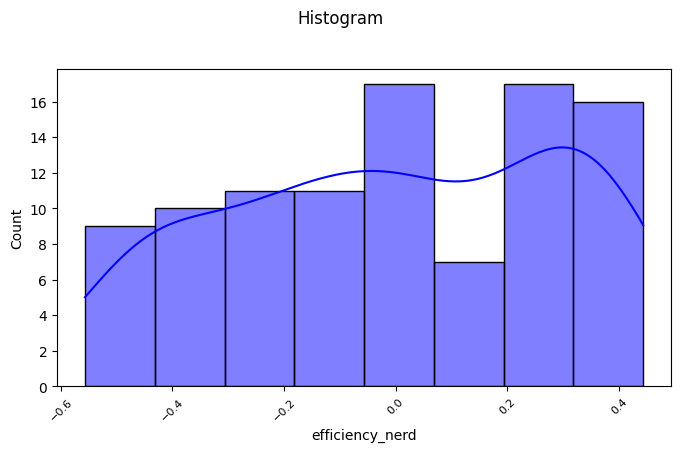

In [392]:
fig= plt.figure(figsize=(8,5))

plt.subplot(111)
sns.histplot(data=cleaned_htest_nerd_df_2,x= "efficiency_nerd", color="blue", kde= True)

fig.tight_layout(pad=5.0)
plt.xticks(rotation=45,fontsize=8)
fig.suptitle("Histogram")

In [394]:
f_oneway(htest_g1["efficiency_nerd"], htest_g2["efficiency_nerd"], htest_g3["efficiency_nerd"], htest_g4["efficiency_nerd"])

F_onewayResult(statistic=0.9678721848616909, pvalue=0.41133745105693864)

<div class="alert alert-block alert-info">
<b>Findings:</b> The F statistic and p-value turn out to be equal to 0.9678 and 0.411 respectively. Since the p-value is not than 0.05 hence we can not reject the null hypothesis. This implies that we have sufficient proof to say that there are no a difference in the performance among different height groups.
</div>



<div class="alert alert-block alert-warning">
<b>Warning:</b> Since the data is not normally distributed the ANOVA test is not perfect fit for Hypothesis Testing
</div>

<div style=" line-height: 60px;height: 100%; font-size: 30px; text-align: center; background-color: OldLace; color: black;">
Option 2. Kruskal-Wallis test
</div>

In [396]:
kruskal(htest_g1["efficiency_nerd"], htest_g2["efficiency_nerd"], htest_g3["efficiency_nerd"], htest_g4["efficiency_nerd"])

KruskalResult(statistic=2.5051338301469035, pvalue=0.4743639997076492)

<div class="alert alert-block alert-info">
<b>Findings:</b> The F statistic and p-value turn out to be equal to 2.505 and 2.505 respectively. Since the p-value is not than 0.05 hence we can not reject the null hypothesis. This implies that we have sufficient proof to say that there are no a difference in the performance among different height groups.
</div>